In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [4]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [5]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [7]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# drugsComTest_raw.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/drive/MyDrive/drugrisk/data/drugsComTrain_raw.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'drugsComTrain_raw.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 7 columns


In [8]:
df1.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


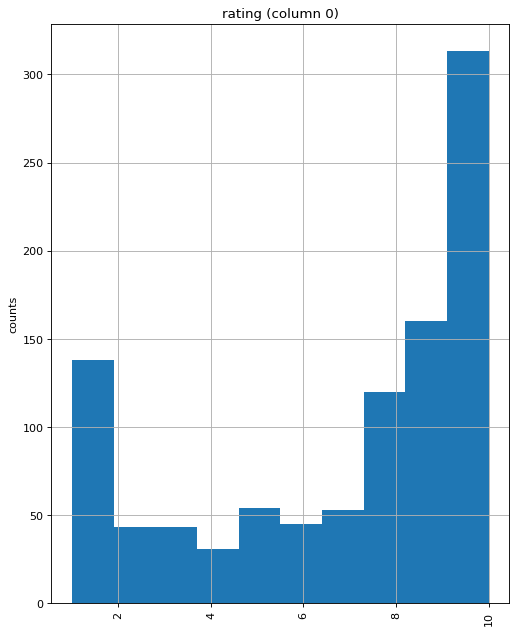

In [9]:
plotPerColumnDistribution(df1, 10, 5)

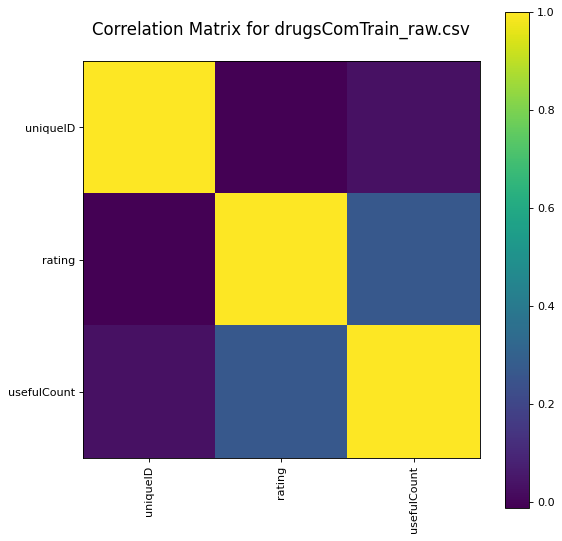

In [10]:
plotCorrelationMatrix(df1, 8)

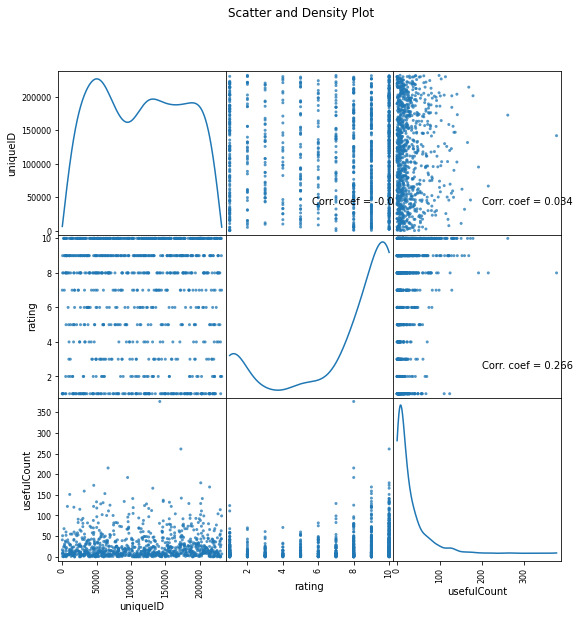

In [11]:
plotScatterMatrix(df1, 9, 10)

In [12]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# drugsComTrain_raw.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('/content/drive/MyDrive/drugrisk/data/drugsComTest_raw.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'drugsComTest_raw.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 7 columns


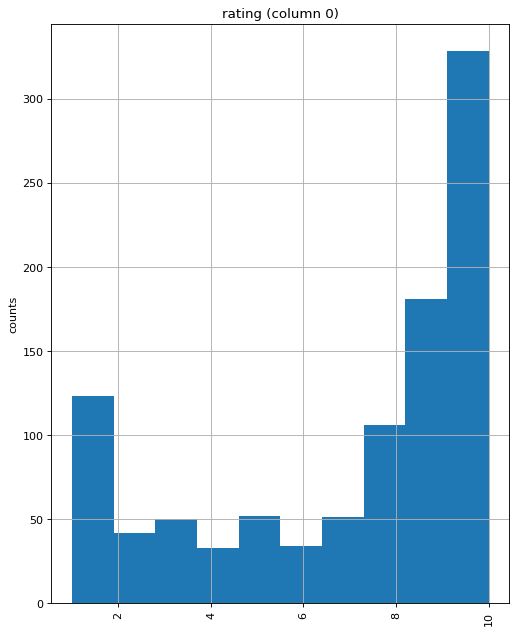

In [13]:
plotPerColumnDistribution(df2, 10, 5)

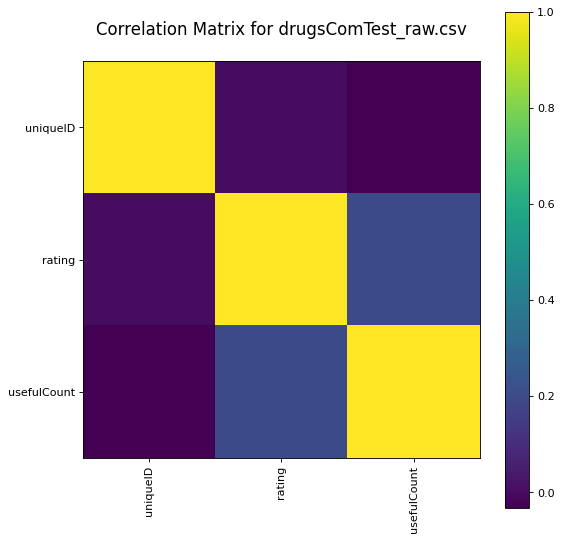

In [14]:
plotCorrelationMatrix(df2, 8)

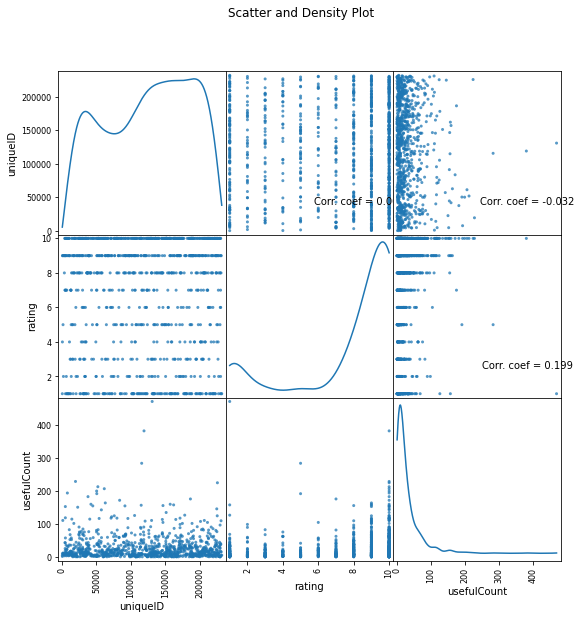

In [15]:
plotScatterMatrix(df2, 9, 10)

In [16]:
import time
import tensorflow as tf
import tensorflow_hub as hub

In [17]:
def load_dataset(file_path, num_samples):
    df = pd.read_csv(file_path, usecols=[3, 4], nrows=num_samples)
    df.columns = ['review', 'rating']

    text = df['review'].tolist()
    text = [str(t).encode('ascii', 'replace') for t in text]
    text = np.array(text, dtype=object)[:]
    
    labels = df['rating'].tolist()
    labels = [1 if i>=7 else 0 if i>=5 else -1 for i in labels]
    labels = np.array(pd.get_dummies(labels), dtype=int)[:] 

    return labels, text

In [18]:
train_labels, train_text = load_dataset('/content/drive/MyDrive/drugrisk/data/drugsComTrain_raw.csv', 568454)
train_text.shape

(161297,)

In [19]:
test_labels, test_text = load_dataset('/content/drive/MyDrive/drugrisk/data/drugsComTest_raw.csv',500000)
test_text.shape

(53766,)

In [20]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[50], 
                           input_shape=[], dtype=tf.string, name='input', trainable=False)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax', name='output'))
model.compile(loss='categorical_crossentropy',
                  optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (KerasLayer)           (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 3075      
Total params: 124,777,859
Trainable params: 135,171
Non-trainable params: 124,642,688
_________________________________________________________________


In [22]:
print("Training the model ...")
history = model.fit(train_text,train_labels, batch_size = 128, epochs=50, verbose=1,
              validation_data=(test_text,test_labels),)

Training the model ...
Epoch 1/5
1261/1261 [==============================] - 33s 26ms/step - loss: 0.6878 - accuracy: 0.7240 - val_loss: 0.6904 - val_accuracy: 0.7223
Epoch 2/5
1261/1261 [==============================] - 29s 23ms/step - loss: 0.6730 - accuracy: 0.7312 - val_loss: 0.6857 - val_accuracy: 0.7265
Epoch 3/5
1261/1261 [==============================] - 27s 22ms/step - loss: 0.6600 - accuracy: 0.7366 - val_loss: 0.6790 - val_accuracy: 0.7282
Epoch 4/5
1261/1261 [==============================] - 25s 20ms/step - loss: 0.6472 - accuracy: 0.7420 - val_loss: 0.6735 - val_accuracy: 0.7296
Epoch 5/5
1261/1261 [==============================] - 25s 20ms/step - loss: 0.6351 - accuracy: 0.7468 - val_loss: 0.6647 - val_accuracy: 0.7325


In [23]:
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

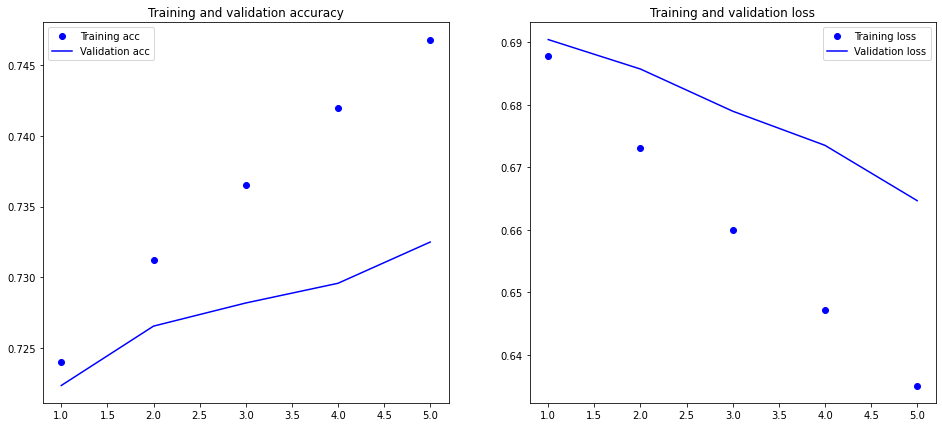

In [24]:
plot_history(history)

In [25]:
model.predict(['im feeling bad'])

array([[0.57525915, 0.08374656, 0.34099436]], dtype=float32)

In [26]:
model.predict(['im feeling sick'])

array([[0.6768392 , 0.07423639, 0.24892437]], dtype=float32)

Machine Learning

In [29]:
import seaborn as sns
%matplotlib inline
from matplotlib import style
style.use('ggplot')

In [30]:
df1.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [31]:
df2.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [32]:
print(f'train has {df1.shape[0]} number of rows and {df1.shape[1]} number of columns')
print(f'train has {df2.shape[0]} number of rows and {df2.shape[1]} number of columns')

train has 1000 number of rows and 7 number of columns
train has 1000 number of rows and 7 number of columns


In [33]:
merge = [df1,df2]
merged_data = pd.concat(merge,ignore_index=True)

merged_data.shape

(2000, 7)

In [34]:
merged_data['uniqueID'].nunique()

2000

In [35]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uniqueID     2000 non-null   int64 
 1   drugName     2000 non-null   object
 2   condition    1991 non-null   object
 3   review       2000 non-null   object
 4   rating       2000 non-null   int64 
 5   date         2000 non-null   object
 6   usefulCount  2000 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 109.5+ KB


In [36]:
merged_data.describe(include='all')

,uniqueID,drugName,condition,review,rating,date,usefulCount
count,2000.000000,2000,1991,2000,2000.000000,2000,2000.000000
unique,NaN,719,270,1991,NaN,1403,NaN
top,NaN,Levonorgestrel,Birth Control,"""Although I loved the fact that this drug all...",NaN,17-Nov-16,NaN
freq,NaN,52,372,2,NaN,5,NaN
mean,118232.214500,NaN,NaN,NaN,6.992500,NaN,27.812500
std,67743.720378,NaN,NaN,NaN,3.275486,NaN,36.919031
min,226.000000,NaN,NaN,NaN,1.000000,NaN,0.000000
25%,58195.750000,NaN,NaN,NaN,4.000000,NaN,6.000000
50%,121315.500000,NaN,NaN,NaN,8.000000,NaN,15.000000
75%,176780.750000,NaN,NaN,NaN,10.000000,NaN,36.000000


In [37]:
merged_data.isnull().sum()/merged_data.shape[0]

uniqueID       0.0000
drugName       0.0000
condition      0.0045
review         0.0000
rating         0.0000
date           0.0000
usefulCount    0.0000
dtype: float64

In [38]:
print(merged_data['drugName'].nunique())
print(merged_data['condition'].nunique())

719
270


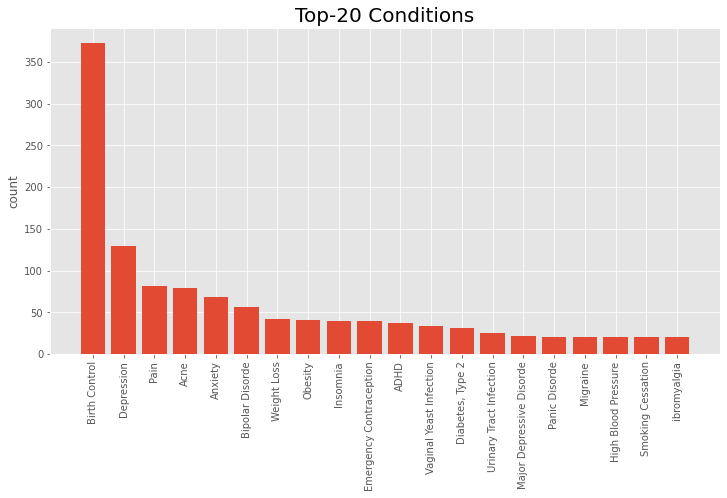

In [39]:
plt.figure(figsize=(12,6))
conditions = merged_data['condition'].value_counts(ascending = False).head(20)
plt.bar(conditions.index,conditions.values)
plt.title('Top-20 Conditions',fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('count')
plt.show()

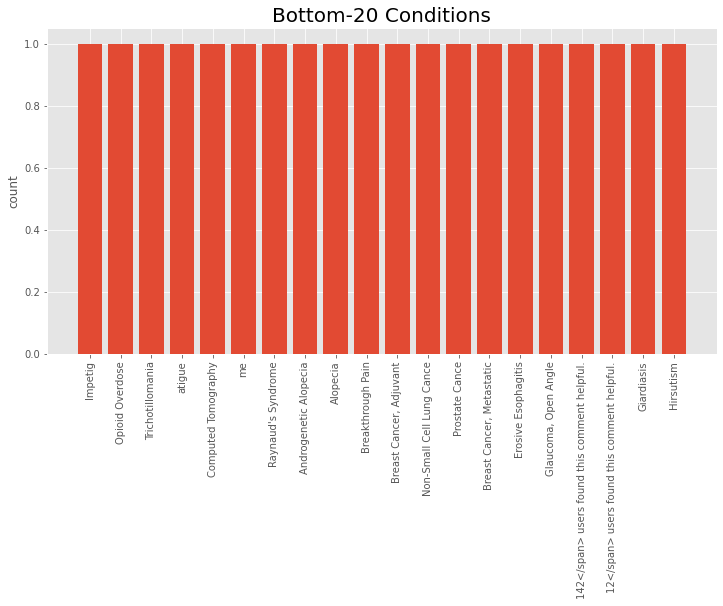

In [40]:
plt.figure(figsize=(12,6))
conditions_bottom = merged_data['condition'].value_counts(ascending = False).tail(20)

plt.bar(conditions_bottom.index,conditions_bottom.values)
plt.title('Bottom-20 Conditions',fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('count')
plt.show()

In [41]:
ratings_ = merged_data['rating'].value_counts().sort_values(ascending=False).reset_index().\
                    rename(columns = {'index' :'rating', 'rating' : 'counts'})
ratings_['percent'] = 100 * (ratings_['counts']/merged_data.shape[0])
print(ratings_)

   rating  counts  percent
0      10     641    32.05
1       9     341    17.05
2       1     261    13.05
3       8     226    11.30
4       5     106     5.30
5       7     104     5.20
6       3      93     4.65
7       2      85     4.25
8       6      79     3.95
9       4      64     3.20


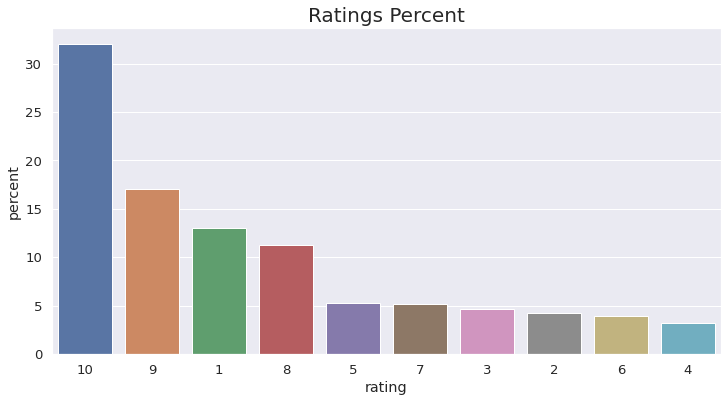

In [42]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]
sns.barplot(x = ratings_['rating'], y = ratings_['percent'],order = ratings_['rating'])
plt.title('Ratings Percent',fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


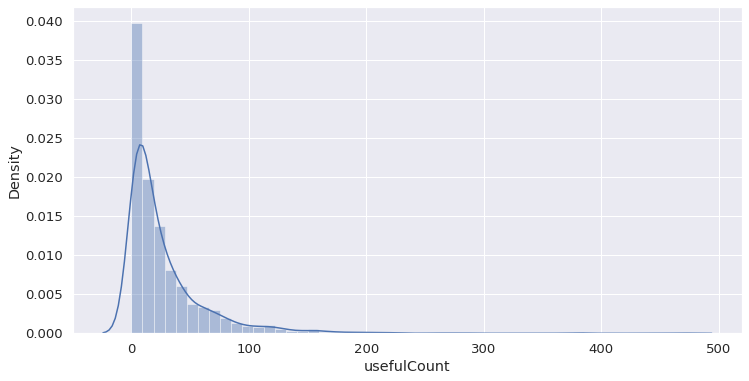

In [43]:
sns.distplot(merged_data['usefulCount'])
plt.show()

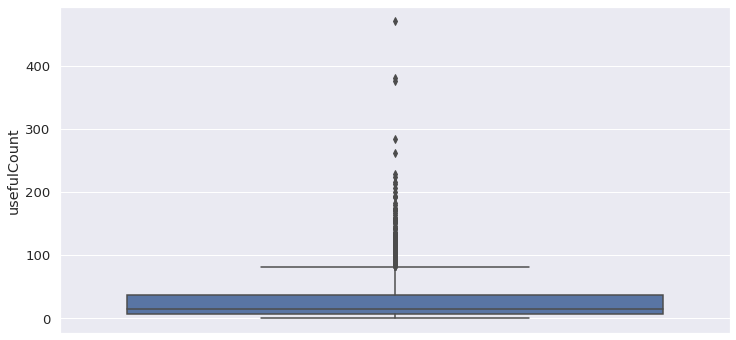

In [44]:
sns.boxplot(y = merged_data['usefulCount'])
plt.show()

In [45]:
merged_data.groupby('condition')['drugName'].nunique().sort_values(ascending=False).head(20)

condition
Birth Control               73
Pain                        46
Depression                  40
Acne                        29
Anxiety                     29
Bipolar Disorde             23
Insomnia                    19
ADHD                        19
Major Depressive Disorde    16
Urinary Tract Infection     14
Diabetes, Type 2            14
ibromyalgia                 13
Migraine                    13
High Blood Pressure         13
Panic Disorde               12
Obesity                     12
Irritable Bowel Syndrome    12
Osteoarthritis              12
Chronic Pain                10
Weight Loss                 10
Name: drugName, dtype: int64

In [46]:
span_data = merged_data[merged_data['condition'].str.contains('</span>',case=False,regex=True) == True]
print('Number of rows with </span> values : ', len(span_data))
noisy_data_ = 100 * (len(span_data)/merged_data.shape[0])
print('Total percent of noisy data {} %  '.format(noisy_data_))

Number of rows with </span> values :  18
Total percent of noisy data 0.8999999999999999 %  


In [47]:
merged_data.drop(span_data.index, axis = 0, inplace=True)

In [48]:
not_listed = merged_data[merged_data['condition'] == 'not listed / othe']
print('Number of not_listed values : ', len(not_listed))
percent_not_listed = 100 * len(not_listed)/merged_data.shape[0]
print('Total percent of noisy data {} %  '.format(percent_not_listed))

Number of not_listed values :  0
Total percent of noisy data 0.0 %  


In [49]:
merged_data.drop(not_listed.index, axis = 0, inplace=True)

In [50]:
conditions_gp = merged_data.groupby('condition')['drugName'].nunique().sort_values(ascending=False)

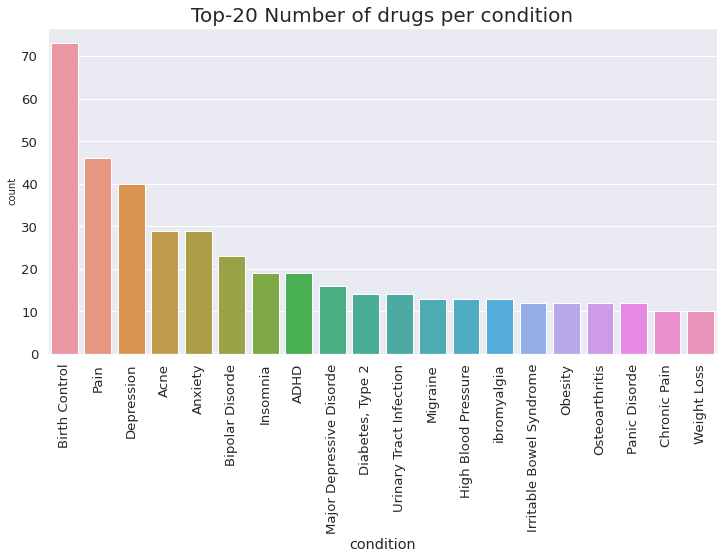

In [51]:
condition_gp_top_20 = conditions_gp.head(20)
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]
sns.barplot(x = condition_gp_top_20.index, y = condition_gp_top_20.values)
plt.title('Top-20 Number of drugs per condition',fontsize=20)
plt.xticks(rotation=90)
plt.ylabel('count',fontsize=10)
plt.show()

In [52]:
drug_multiple_cond = merged_data.groupby('drugName')['condition'].nunique().sort_values(ascending=False)
print(drug_multiple_cond.head(10))

drugName
Metronidazole                      7
Zoloft                             7
Gabapentin                         7
Sertraline                         6
Clonazepam                         6
Levofloxacin                       5
Duloxetine                         5
Clindamycin                        5
Metoprolol                         5
Sulfamethoxazole / trimethoprim    5
Name: condition, dtype: int64


In [53]:
merged_data[merged_data['rating'] == 10]['drugName'].nunique()

356

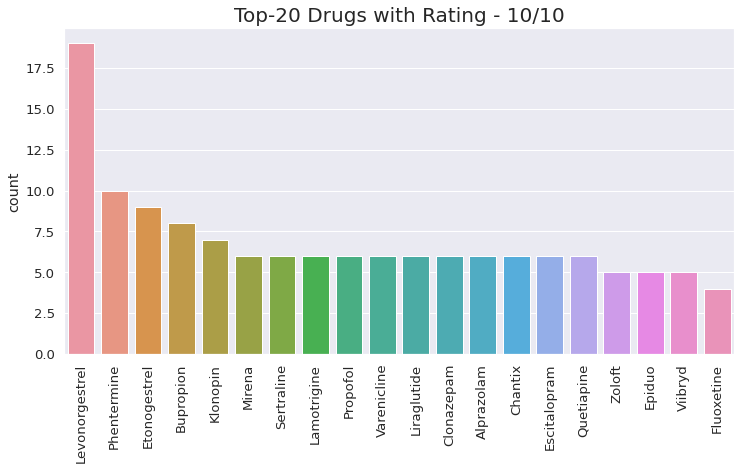

In [54]:
top_20_ratings = merged_data[merged_data['rating'] == 10]['drugName'].value_counts().head(20)
sns.barplot(x = top_20_ratings.index, y = top_20_ratings.values )
plt.xticks(rotation=90)
plt.title('Top-20 Drugs with Rating - 10/10', fontsize=20)
plt.ylabel('count')
plt.show()

In [55]:
merged_data[merged_data['drugName'] == 'Levonorgestrel']['condition'].unique()

array(['Emergency Contraception', 'Birth Control',
       'Abnormal Uterine Bleeding', nan], dtype=object)

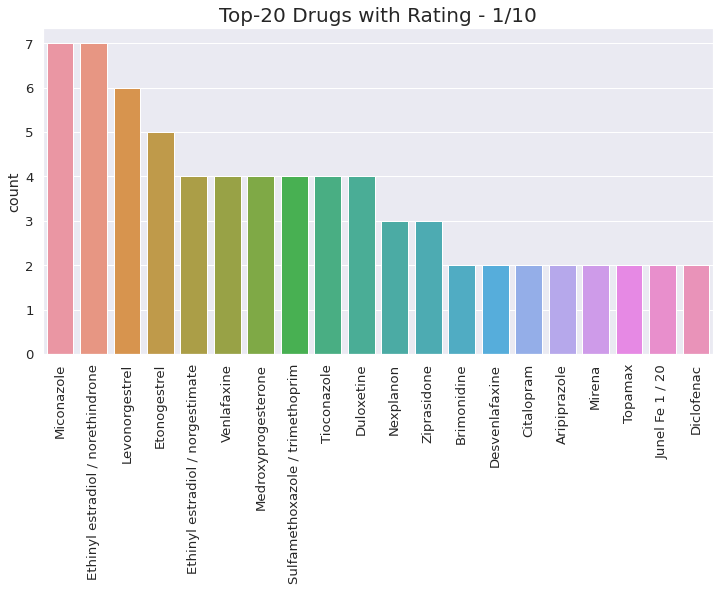

In [56]:
top_20_ratings_1 = merged_data[merged_data['rating'] == 1]['drugName'].value_counts().head(20)
sns.barplot(x = top_20_ratings_1.index, y = top_20_ratings_1.values )
plt.xticks(rotation=90)
plt.title('Top-20 Drugs with Rating - 1/10', fontsize=20)
plt.ylabel('count')
plt.show()

convert date to datetime and create year andd month features

In [57]:
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['year'] = merged_data['date'].dt.year  #create year
merged_data['month'] = merged_data['date'].dt.month #create month

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


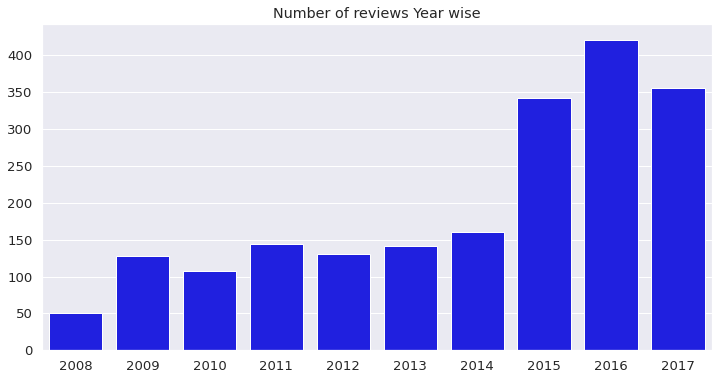

In [58]:
count_reviews = merged_data['year'].value_counts().sort_index()
sns.barplot(count_reviews.index,count_reviews.values,color='blue')
plt.title('Number of reviews Year wise')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


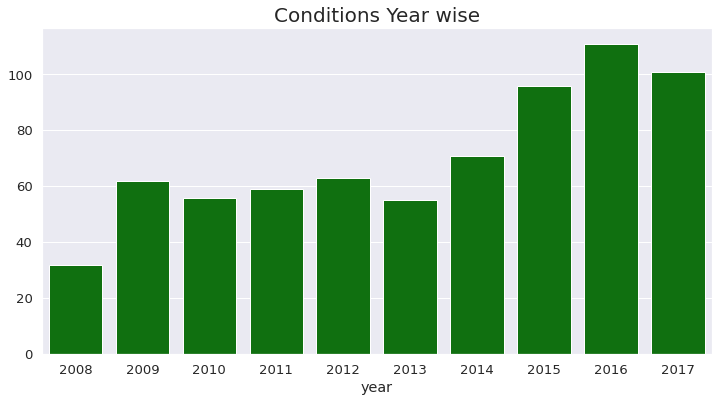

In [59]:
year_wise_condition = merged_data.groupby('year')['condition'].nunique()
sns.barplot(year_wise_condition.index,year_wise_condition.values,color='green')
plt.title('Conditions Year wise',fontsize=20)
plt.show()

In [60]:
merged_data.isnull().sum()

uniqueID       0
drugName       0
condition      9
review         0
rating         0
date           0
usefulCount    0
year           0
month          0
dtype: int64

In [61]:
merged_data.dropna(inplace=True, axis=0)

In [62]:
for i in merged_data['review'][0:3]:
    print(i,'\n')

"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil" 

"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and so far this is the most effective." 

"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestod

pre-processing

In [63]:
from bs4 import BeautifulSoup
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [65]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [66]:
stops = set(stopwords.words('english')) #english stopwords

stemmer = SnowballStemmer('english') #SnowballStemmer

In [67]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [68]:
merged_data['review'] = merged_data['review'].apply(review_to_words)

In [69]:
merged_data['sentiment'] = merged_data["rating"].apply(lambda x: 1 if x > 5 else 0)

Deployment of ML

In [70]:
from sklearn.model_selection import train_test_split #import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer #import TfidfVectorizer 
from sklearn.metrics import confusion_matrix #import confusion_matrix

TF-IDF vectorizer and transforms the corpus

In [71]:
vectorizer = TfidfVectorizer()
reviews_corpus = vectorizer.fit_transform(merged_data.review)
reviews_corpus.shape

(1973, 5389)

In [72]:
sentiment = merged_data['sentiment']
sentiment.shape

(1973,)

DAta Splitting

In [73]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(reviews_corpus,sentiment,test_size=0.33,random_state=42)
print('Train data shape ',X_train.shape,Y_train.shape)
print('Test data shape ',X_test.shape,Y_test.shape)

Train data shape  (1321, 5389) (1321,)
Test data shape  (652, 5389) (652,)


# **RandomForestClassifier**

In [74]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier().fit(X_train, Y_train)
pred = RF.predict(X_test)

print("Accuracy: %s" % str(RF.score(X_test, Y_test)))
print("Confusion Matrix")
print(confusion_matrix(pred, Y_test))

Accuracy: 0.7438650306748467
Confusion Matrix
[[ 34   7]
 [160 451]]


# **DecisionTreeClassifier**

In [75]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier().fit(X_train, Y_train)
pred = DT.predict(X_test)

print("Accuracy: %s" % str(DT.score(X_test, Y_test)))
print("Confusion Matrix")
print(confusion_matrix(pred, Y_test))

Accuracy: 0.6503067484662577
Confusion Matrix
[[ 86 120]
 [108 338]]


# **LogisticRegression**

In [76]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression().fit(X_train, Y_train)
pred = LR.predict(X_test)

print("Accuracy: %s" % str(LR.score(X_test, Y_test)))
print("Confusion Matrix")
print(confusion_matrix(pred, Y_test))

Accuracy: 0.7361963190184049
Confusion Matrix
[[ 27   5]
 [167 453]]


# **GradientBoostingClassifier**

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier().fit(X_train, Y_train)
pred = GB.predict(X_test)

print("Accuracy: %s" % str(GB.score(X_test, Y_test)))
print("Confusion Matrix")
print(confusion_matrix(pred, Y_test))

Accuracy: 0.7177914110429447
Confusion Matrix
[[ 51  41]
 [143 417]]


# **AdaBoostClassifier**

In [78]:
from sklearn.ensemble import AdaBoostClassifier
AB = AdaBoostClassifier().fit(X_train, Y_train)
pred = AB.predict(X_test)

print("Accuracy: %s" % str(AB.score(X_test, Y_test)))
print("Confusion Matrix")
print(confusion_matrix(pred, Y_test))

Accuracy: 0.7070552147239264
Confusion Matrix
[[ 74  71]
 [120 387]]


# **OverSampling with SMOTE**

In [79]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train , Y_train = sm.fit_sample(X_train, Y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [80]:
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(Y_train.shape))

After OverSampling, the shape of train_X: (1834, 5389)
After OverSampling, the shape of train_y: (1834,) 



**ANALYSIS with Logistic Regression with Oversmapling**

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [82]:
parameters = {
    'C': np.linspace(1, 10, 10)
             }

In [83]:
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train, Y_train.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    4.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [84]:
clf.best_params_

{'C': 7.0}

In [86]:
lr = LogisticRegression(C=4,penalty='l2', verbose=5)
lr.fit(X_train, Y_train.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=5,
                   warm_start=False)

In [87]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 98.69138495092693%


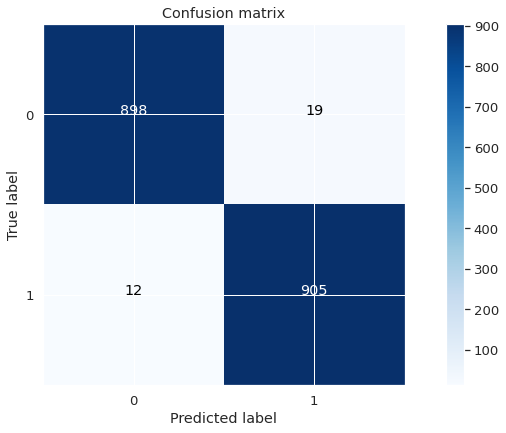

In [89]:
y_train_pre = lr.predict(X_train)

cnf_matrix_tra = confusion_matrix(Y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 82.31441048034935%


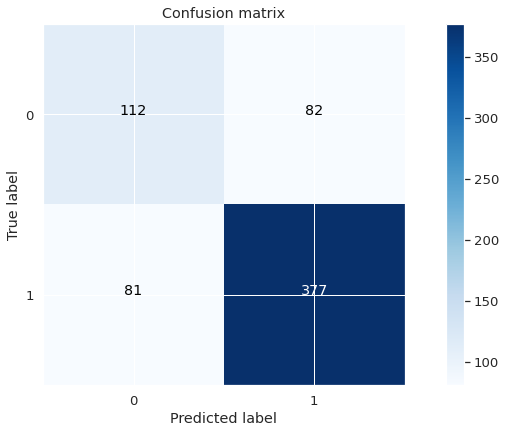

In [90]:
y_pre = lr.predict(X_test)

cnf_matrix = confusion_matrix(Y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [91]:
tmp = lr.fit(X_train, Y_train.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


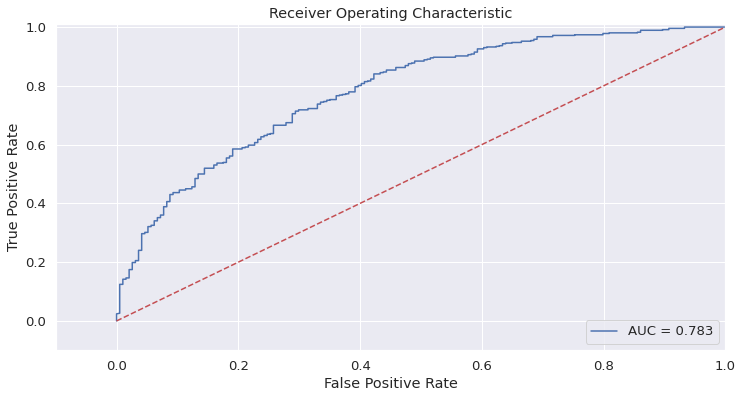

In [93]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(Y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [96]:
Smote_LR = roc_auc
print(Smote_LR)

0.7828017377211542


# **Accuracy Comparsion**

In [97]:
#make variabel for save the result and to show it
classifier = ('Random Forest','Decision Tree','Logistic Regression','Gradient Boosting','Ada Boosting','SMOTE OVERSAMPLING with LR')
y_pos = np.arange(len(classifier))
print(y_pos)
score = [RF.score(X_test, Y_test),DT.score(X_test, Y_test),LR.score(X_test, Y_test),GB.score(X_test, Y_test),AB.score(X_test, Y_test),Smote_LR]
print(score)

[0 1 2 3 4 5]
[0.7438650306748467, 0.6503067484662577, 0.7361963190184049, 0.7177914110429447, 0.7070552147239264, 0.7828017377211542]


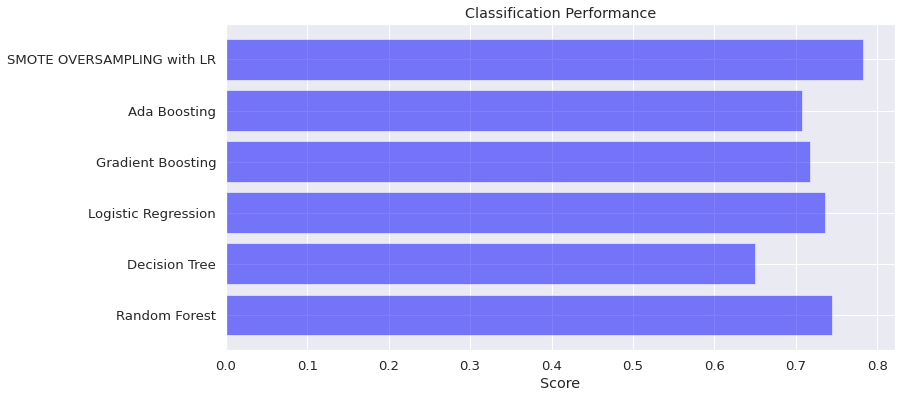

In [98]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Classification Performance')
plt2.show()